In [27]:
# Import libs
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import os 
import sys
import random
import cv2
from tqdm import tqdm

from keras.models import Model, load_model
from keras.layers import Input, Dense, MaxPooling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers

import tensorflow as tf

In [28]:
np.random.seed = 1337

# Set operating parameters
TRAIN_IMG_PATH = 'training_images'
VALID_IMG_PATH = 'validation_images'
TEST_IMG_PATH = 'testing_images'
TRAIN_MASK_PATH = 'train_target'

IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

In [29]:
# Get list of training and testing filenames
train_ids = next(os.walk(TRAIN_IMG_PATH))[2]
test_ids = next(os.walk(TEST_IMG_PATH))[2]
train_masks = next(os.walk(TRAIN_MASK_PATH))[2]

print(train_ids)
#print(test_ids)
print(train_masks)

['train_img_1.jpg', 'train_img_10.jpg', 'train_img_100.jpg', 'train_img_1000.jpg', 'train_img_1001.jpg', 'train_img_1002.jpg', 'train_img_1003.jpg', 'train_img_1004.jpg', 'train_img_1005.jpg', 'train_img_1006.jpg', 'train_img_1007.jpg', 'train_img_1008.jpg', 'train_img_1009.jpg', 'train_img_101.jpg', 'train_img_1010.jpg', 'train_img_1011.jpg', 'train_img_1012.jpg', 'train_img_1013.jpg', 'train_img_1014.jpg', 'train_img_1015.jpg', 'train_img_1016.jpg', 'train_img_1017.jpg', 'train_img_1018.jpg', 'train_img_1019.jpg', 'train_img_102.jpg', 'train_img_1020.jpg', 'train_img_1021.jpg', 'train_img_1022.jpg', 'train_img_1023.jpg', 'train_img_1024.jpg', 'train_img_1025.jpg', 'train_img_1026.jpg', 'train_img_1027.jpg', 'train_img_1028.jpg', 'train_img_1029.jpg', 'train_img_103.jpg', 'train_img_1030.jpg', 'train_img_1031.jpg', 'train_img_1032.jpg', 'train_img_1033.jpg', 'train_img_1034.jpg', 'train_img_1035.jpg', 'train_img_1036.jpg', 'train_img_1037.jpg', 'train_img_1038.jpg', 'train_img_1039.jp


['train_mask_1.jpg', 'train_mask_10.jpg', 'train_mask_100.jpg', 'train_mask_1000.jpg', 'train_mask_1001.jpg', 'train_mask_1002.jpg', 'train_mask_1003.jpg', 'train_mask_1004.jpg', 'train_mask_1005.jpg', 'train_mask_1006.jpg', 'train_mask_1007.jpg', 'train_mask_1008.jpg', 'train_mask_1009.jpg', 'train_mask_101.jpg', 'train_mask_1010.jpg', 'train_mask_1011.jpg', 'train_mask_1012.jpg', 'train_mask_1013.jpg', 'train_mask_1014.jpg', 'train_mask_1015.jpg', 'train_mask_1016.jpg', 'train_mask_1017.jpg', 'train_mask_1018.jpg', 'train_mask_1019.jpg', 'train_mask_102.jpg', 'train_mask_1020.jpg', 'train_mask_1021.jpg', 'train_mask_1022.jpg', 'train_mask_1023.jpg', 'train_mask_1024.jpg', 'train_mask_1025.jpg', 'train_mask_1026.jpg', 'train_mask_1027.jpg', 'train_mask_1028.jpg', 'train_mask_1029.jpg', 'train_mask_103.jpg', 'train_mask_1030.jpg', 'train_mask_1031.jpg', 'train_mask_1032.jpg', 'train_mask_1033.jpg', 'train_mask_1034.jpg', 'train_mask_1035.jpg', 'train_mask_1036.jpg', 'train_mask_1037.j

In [30]:
# Get and resize training images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing training images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

# Get and resize training mask images
Y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing training masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_masks), total=len(train_masks)):
    path = TRAIN_MASK_PATH + '/' + id_
    mask = imread(path)[:,:]
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_IMG_PATH + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 173.84it/s]


Getting and resizing training masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 519.07it/s]


Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 927/927 [00:05<00:00, 177.48it/s]


Done!


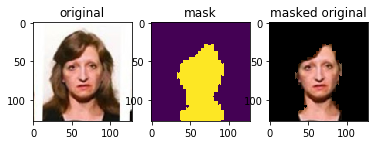

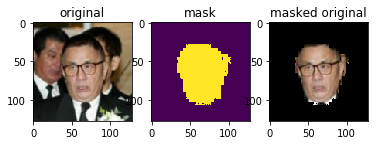

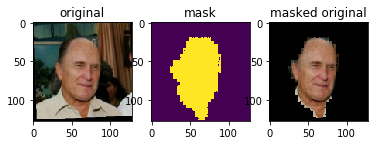

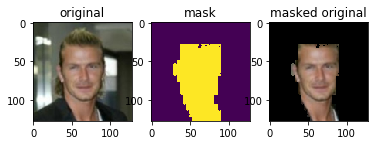

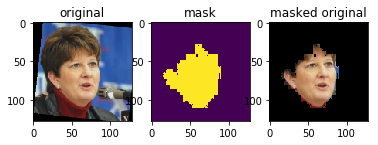

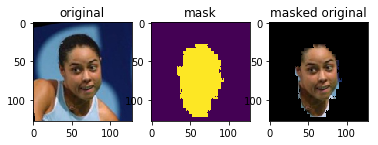

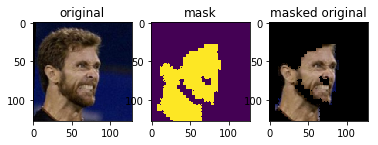

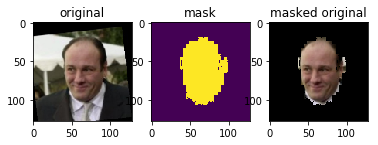

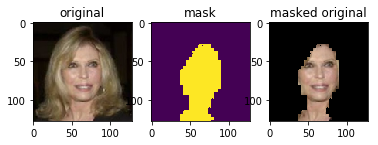

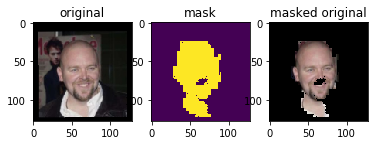

In [31]:
# Check if training and mask data looks all right
for ix in np.arange(10):
    # Mask should be a 2D array for plot
    mask = np.squeeze(Y_train[ix])

    # Create a masked image
    masked = np.copy(X_train[ix]) * Y_train[ix]
    
    # Display original, mask, and masked images side-by-side
    f, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.set_title('original')
    ax0.imshow(X_train[ix])
    ax1.set_title('mask')
    ax1.imshow(mask)
    ax2.set_title('masked original')
    ax2.imshow(masked)
    plt.show()

In [32]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [33]:
# Define a U-Net neural network
def unet(height, width, num_channels):
    inputs = Input((height, width, num_channels))
    inputs_ = Lambda(lambda x: x / 255) (inputs)

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1_1') (inputs_)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1_2') (conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1') (conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2_1') (pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2_2') (conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2') (conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3_1') (pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv3_2') (conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3') (conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4_1') (pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4_2') (conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4') (conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv5_1') (pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv5_2') (conv5)

    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv6_1') (up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv6_2') (conv6)

    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv7_1') (up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv7_2') (conv7)

    up8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv8_1') (up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv8_2') (conv8)

    up9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv9_1') (up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv9_2') (conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [34]:
# Build U-Net model
model = unet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

adam = optimizers.Adam(lr=0.001, decay =0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[mean_iou])

# Fit model
earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-skin-1.h5', save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=10, epochs=50, 
                    callbacks=[earlystopper, checkpointer]) # verbose=1(before save_best_only = True) batch_size=8, epochs=10

Train on 1200 samples, validate on 300 samples
Epoch 1/50
1200/1200 [==============================] - ETA: 4:23 - loss: 0.6943 - mean_iou: 0.0000e+ - ETA: 3:47 - loss: 0.6930 - mean_iou: 0.1778   - ETA: 3:29 - loss: 0.6921 - mean_iou: 0.24 - ETA: 3:20 - loss: 0.6911 - mean_iou: 0.27 - ETA: 3:16 - loss: 0.6895 - mean_iou: 0.29 - ETA: 3:14 - loss: 0.6873 - mean_iou: 0.30 - ETA: 3:11 - loss: 0.6852 - mean_iou: 0.31 - ETA: 3:07 - loss: 0.6837 - mean_iou: 0.32 - ETA: 3:05 - loss: 0.6820 - mean_iou: 0.32 - ETA: 3:03 - loss: 0.6784 - mean_iou: 0.33 - ETA: 3:00 - loss: 0.6739 - mean_iou: 0.33 - ETA: 2:57 - loss: 0.6723 - mean_iou: 0.33 - ETA: 2:55 - loss: 0.6712 - mean_iou: 0.34 - ETA: 2:53 - loss: 0.6670 - mean_iou: 0.34 - ETA: 2:51 - loss: 0.6636 - mean_iou: 0.34 - ETA: 2:49 - loss: 0.6599 - mean_iou: 0.34 - ETA: 2:47 - loss: 0.6572 - mean_iou: 0.34 - ETA: 2:45 - loss: 0.6548 - mean_iou: 0.35 - ETA: 2:43 - loss: 0.6510 - mean_iou: 0.35 - ETA: 2:41 - loss: 0.6476 - mean_iou: 0.35 - ETA: 2:40

1200/1200 [==============================] - ETA: 3:10 - loss: 0.1700 - mean_iou: 0.70 - ETA: 3:07 - loss: 0.1519 - mean_iou: 0.70 - ETA: 3:09 - loss: 0.1440 - mean_iou: 0.70 - ETA: 3:12 - loss: 0.1455 - mean_iou: 0.70 - ETA: 3:09 - loss: 0.1414 - mean_iou: 0.70 - ETA: 3:07 - loss: 0.1439 - mean_iou: 0.70 - ETA: 3:06 - loss: 0.1411 - mean_iou: 0.70 - ETA: 3:05 - loss: 0.1433 - mean_iou: 0.70 - ETA: 3:03 - loss: 0.1402 - mean_iou: 0.70 - ETA: 3:01 - loss: 0.1379 - mean_iou: 0.70 - ETA: 3:00 - loss: 0.1398 - mean_iou: 0.70 - ETA: 2:59 - loss: 0.1410 - mean_iou: 0.70 - ETA: 2:57 - loss: 0.1450 - mean_iou: 0.70 - ETA: 2:55 - loss: 0.1447 - mean_iou: 0.70 - ETA: 2:53 - loss: 0.1472 - mean_iou: 0.70 - ETA: 2:52 - loss: 0.1470 - mean_iou: 0.70 - ETA: 2:50 - loss: 0.1497 - mean_iou: 0.70 - ETA: 2:48 - loss: 0.1533 - mean_iou: 0.70 - ETA: 2:47 - loss: 0.1551 - mean_iou: 0.70 - ETA: 2:45 - loss: 0.1556 - mean_iou: 0.70 - ETA: 2:44 - loss: 0.1550 - mean_iou: 0.70 - ETA: 2:42 - loss: 0.1563 - mean

1200/1200 [==============================] - ETA: 3:10 - loss: 0.1364 - mean_iou: 0.76 - ETA: 3:09 - loss: 0.1261 - mean_iou: 0.76 - ETA: 3:13 - loss: 0.1262 - mean_iou: 0.76 - ETA: 3:12 - loss: 0.1172 - mean_iou: 0.76 - ETA: 3:09 - loss: 0.1156 - mean_iou: 0.76 - ETA: 3:07 - loss: 0.1121 - mean_iou: 0.76 - ETA: 3:06 - loss: 0.1189 - mean_iou: 0.76 - ETA: 3:05 - loss: 0.1162 - mean_iou: 0.76 - ETA: 3:03 - loss: 0.1171 - mean_iou: 0.76 - ETA: 3:02 - loss: 0.1178 - mean_iou: 0.76 - ETA: 3:01 - loss: 0.1189 - mean_iou: 0.76 - ETA: 3:00 - loss: 0.1193 - mean_iou: 0.76 - ETA: 2:58 - loss: 0.1198 - mean_iou: 0.76 - ETA: 2:56 - loss: 0.1216 - mean_iou: 0.76 - ETA: 2:55 - loss: 0.1213 - mean_iou: 0.76 - ETA: 2:53 - loss: 0.1221 - mean_iou: 0.76 - ETA: 2:52 - loss: 0.1230 - mean_iou: 0.76 - ETA: 2:50 - loss: 0.1257 - mean_iou: 0.76 - ETA: 2:48 - loss: 0.1241 - mean_iou: 0.76 - ETA: 2:47 - loss: 0.1241 - mean_iou: 0.76 - ETA: 2:45 - loss: 0.1280 - mean_iou: 0.76 - ETA: 2:43 - loss: 0.1282 - mean

1200/1200 [==============================] - ETA: 3:11 - loss: 0.1147 - mean_iou: 0.79 - ETA: 3:12 - loss: 0.1007 - mean_iou: 0.79 - ETA: 3:13 - loss: 0.1094 - mean_iou: 0.79 - ETA: 3:14 - loss: 0.1106 - mean_iou: 0.79 - ETA: 3:11 - loss: 0.1083 - mean_iou: 0.79 - ETA: 3:08 - loss: 0.1122 - mean_iou: 0.79 - ETA: 3:08 - loss: 0.1089 - mean_iou: 0.79 - ETA: 3:07 - loss: 0.1057 - mean_iou: 0.79 - ETA: 3:05 - loss: 0.1054 - mean_iou: 0.79 - ETA: 3:03 - loss: 0.1051 - mean_iou: 0.79 - ETA: 3:02 - loss: 0.1035 - mean_iou: 0.79 - ETA: 3:01 - loss: 0.1041 - mean_iou: 0.79 - ETA: 2:58 - loss: 0.1033 - mean_iou: 0.79 - ETA: 2:57 - loss: 0.1040 - mean_iou: 0.79 - ETA: 2:55 - loss: 0.1041 - mean_iou: 0.79 - ETA: 2:54 - loss: 0.1042 - mean_iou: 0.79 - ETA: 2:52 - loss: 0.1045 - mean_iou: 0.79 - ETA: 2:50 - loss: 0.1039 - mean_iou: 0.79 - ETA: 2:49 - loss: 0.1062 - mean_iou: 0.79 - ETA: 2:47 - loss: 0.1055 - mean_iou: 0.79 - ETA: 2:45 - loss: 0.1047 - mean_iou: 0.79 - ETA: 2:44 - loss: 0.1053 - mean

1200/1200 [==============================] - ETA: 3:11 - loss: 0.1429 - mean_iou: 0.80 - ETA: 3:20 - loss: 0.1255 - mean_iou: 0.80 - ETA: 3:16 - loss: 0.1205 - mean_iou: 0.80 - ETA: 3:13 - loss: 0.1216 - mean_iou: 0.80 - ETA: 3:10 - loss: 0.1236 - mean_iou: 0.80 - ETA: 3:11 - loss: 0.1207 - mean_iou: 0.80 - ETA: 3:09 - loss: 0.1172 - mean_iou: 0.80 - ETA: 3:06 - loss: 0.1137 - mean_iou: 0.80 - ETA: 3:04 - loss: 0.1136 - mean_iou: 0.80 - ETA: 3:04 - loss: 0.1132 - mean_iou: 0.80 - ETA: 3:02 - loss: 0.1138 - mean_iou: 0.80 - ETA: 3:00 - loss: 0.1115 - mean_iou: 0.80 - ETA: 2:58 - loss: 0.1092 - mean_iou: 0.80 - ETA: 2:57 - loss: 0.1073 - mean_iou: 0.80 - ETA: 2:55 - loss: 0.1101 - mean_iou: 0.80 - ETA: 2:53 - loss: 0.1089 - mean_iou: 0.80 - ETA: 2:51 - loss: 0.1071 - mean_iou: 0.80 - ETA: 2:50 - loss: 0.1068 - mean_iou: 0.80 - ETA: 2:48 - loss: 0.1074 - mean_iou: 0.80 - ETA: 2:46 - loss: 0.1075 - mean_iou: 0.80 - ETA: 2:45 - loss: 0.1069 - mean_iou: 0.80 - ETA: 2:44 - loss: 0.1073 - mean

1200/1200 [==============================] - ETA: 3:13 - loss: 0.0927 - mean_iou: 0.81 - ETA: 3:15 - loss: 0.1073 - mean_iou: 0.81 - ETA: 3:16 - loss: 0.1199 - mean_iou: 0.81 - ETA: 3:12 - loss: 0.1168 - mean_iou: 0.81 - ETA: 3:10 - loss: 0.1154 - mean_iou: 0.81 - ETA: 3:09 - loss: 0.1191 - mean_iou: 0.81 - ETA: 3:08 - loss: 0.1143 - mean_iou: 0.81 - ETA: 3:06 - loss: 0.1125 - mean_iou: 0.81 - ETA: 3:04 - loss: 0.1105 - mean_iou: 0.81 - ETA: 3:02 - loss: 0.1089 - mean_iou: 0.81 - ETA: 3:01 - loss: 0.1055 - mean_iou: 0.81 - ETA: 3:00 - loss: 0.1042 - mean_iou: 0.81 - ETA: 2:58 - loss: 0.1028 - mean_iou: 0.81 - ETA: 2:57 - loss: 0.1016 - mean_iou: 0.81 - ETA: 2:56 - loss: 0.1031 - mean_iou: 0.81 - ETA: 2:54 - loss: 0.1026 - mean_iou: 0.81 - ETA: 2:52 - loss: 0.1031 - mean_iou: 0.81 - ETA: 2:50 - loss: 0.1032 - mean_iou: 0.81 - ETA: 2:49 - loss: 0.1038 - mean_iou: 0.81 - ETA: 2:47 - loss: 0.1030 - mean_iou: 0.81 - ETA: 2:45 - loss: 0.1022 - mean_iou: 0.81 - ETA: 2:44 - loss: 0.1019 - mean

1200/1200 [==============================] - ETA: 3:19 - loss: 0.0792 - mean_iou: 0.82 - ETA: 3:16 - loss: 0.0781 - mean_iou: 0.82 - ETA: 3:18 - loss: 0.0916 - mean_iou: 0.82 - ETA: 3:16 - loss: 0.0905 - mean_iou: 0.82 - ETA: 3:14 - loss: 0.0876 - mean_iou: 0.82 - ETA: 3:12 - loss: 0.0946 - mean_iou: 0.82 - ETA: 3:13 - loss: 0.0977 - mean_iou: 0.82 - ETA: 3:11 - loss: 0.1037 - mean_iou: 0.82 - ETA: 3:09 - loss: 0.1084 - mean_iou: 0.82 - ETA: 3:07 - loss: 0.1068 - mean_iou: 0.82 - ETA: 3:07 - loss: 0.1067 - mean_iou: 0.82 - ETA: 3:05 - loss: 0.1044 - mean_iou: 0.82 - ETA: 3:02 - loss: 0.1038 - mean_iou: 0.82 - ETA: 3:01 - loss: 0.1024 - mean_iou: 0.82 - ETA: 3:00 - loss: 0.1016 - mean_iou: 0.82 - ETA: 2:58 - loss: 0.1003 - mean_iou: 0.82 - ETA: 2:57 - loss: 0.1021 - mean_iou: 0.82 - ETA: 2:56 - loss: 0.1027 - mean_iou: 0.82 - ETA: 2:55 - loss: 0.1013 - mean_iou: 0.82 - ETA: 2:53 - loss: 0.1019 - mean_iou: 0.82 - ETA: 2:51 - loss: 0.1012 - mean_iou: 0.82 - ETA: 2:50 - loss: 0.0993 - mean

1200/1200 [==============================] - ETA: 3:19 - loss: 0.0781 - mean_iou: 0.83 - ETA: 3:48 - loss: 0.0814 - mean_iou: 0.83 - ETA: 3:45 - loss: 0.0900 - mean_iou: 0.83 - ETA: 3:36 - loss: 0.0950 - mean_iou: 0.83 - ETA: 3:30 - loss: 0.0945 - mean_iou: 0.83 - ETA: 3:24 - loss: 0.0927 - mean_iou: 0.83 - ETA: 3:21 - loss: 0.0924 - mean_iou: 0.83 - ETA: 3:22 - loss: 0.0952 - mean_iou: 0.83 - ETA: 3:24 - loss: 0.0943 - mean_iou: 0.83 - ETA: 3:20 - loss: 0.0964 - mean_iou: 0.83 - ETA: 3:17 - loss: 0.0955 - mean_iou: 0.83 - ETA: 3:15 - loss: 0.0957 - mean_iou: 0.83 - ETA: 3:14 - loss: 0.0941 - mean_iou: 0.83 - ETA: 3:15 - loss: 0.0944 - mean_iou: 0.83 - ETA: 3:12 - loss: 0.0945 - mean_iou: 0.83 - ETA: 3:09 - loss: 0.0949 - mean_iou: 0.83 - ETA: 3:06 - loss: 0.0949 - mean_iou: 0.83 - ETA: 3:04 - loss: 0.0952 - mean_iou: 0.83 - ETA: 3:02 - loss: 0.0948 - mean_iou: 0.83 - ETA: 3:02 - loss: 0.0936 - mean_iou: 0.83 - ETA: 3:00 - loss: 0.0942 - mean_iou: 0.83 - ETA: 2:58 - loss: 0.0931 - mean

1200/1200 [==============================] - ETA: 4:07 - loss: 0.0759 - mean_iou: 0.84 - ETA: 3:44 - loss: 0.0714 - mean_iou: 0.84 - ETA: 3:34 - loss: 0.0782 - mean_iou: 0.84 - ETA: 3:28 - loss: 0.0771 - mean_iou: 0.84 - ETA: 3:26 - loss: 0.0780 - mean_iou: 0.84 - ETA: 3:26 - loss: 0.0764 - mean_iou: 0.84 - ETA: 3:31 - loss: 0.0751 - mean_iou: 0.84 - ETA: 3:29 - loss: 0.0762 - mean_iou: 0.84 - ETA: 3:29 - loss: 0.0750 - mean_iou: 0.84 - ETA: 3:30 - loss: 0.0771 - mean_iou: 0.84 - ETA: 3:28 - loss: 0.0757 - mean_iou: 0.84 - ETA: 3:24 - loss: 0.0754 - mean_iou: 0.84 - ETA: 3:20 - loss: 0.0782 - mean_iou: 0.84 - ETA: 3:17 - loss: 0.0789 - mean_iou: 0.84 - ETA: 3:14 - loss: 0.0783 - mean_iou: 0.84 - ETA: 3:14 - loss: 0.0782 - mean_iou: 0.84 - ETA: 3:12 - loss: 0.0780 - mean_iou: 0.84 - ETA: 3:09 - loss: 0.0796 - mean_iou: 0.84 - ETA: 3:07 - loss: 0.0805 - mean_iou: 0.84 - ETA: 3:04 - loss: 0.0795 - mean_iou: 0.84 - ETA: 3:02 - loss: 0.0798 - mean_iou: 0.84 - ETA: 2:59 - loss: 0.0801 - mean

1200/1200 [==============================] - ETA: 3:09 - loss: 0.1051 - mean_iou: 0.84 - ETA: 3:05 - loss: 0.0965 - mean_iou: 0.84 - ETA: 3:06 - loss: 0.0948 - mean_iou: 0.84 - ETA: 3:19 - loss: 0.0918 - mean_iou: 0.84 - ETA: 3:19 - loss: 0.0902 - mean_iou: 0.84 - ETA: 3:17 - loss: 0.0894 - mean_iou: 0.84 - ETA: 3:16 - loss: 0.0889 - mean_iou: 0.84 - ETA: 3:13 - loss: 0.0878 - mean_iou: 0.84 - ETA: 3:12 - loss: 0.0883 - mean_iou: 0.84 - ETA: 3:14 - loss: 0.0872 - mean_iou: 0.84 - ETA: 3:16 - loss: 0.0885 - mean_iou: 0.84 - ETA: 3:12 - loss: 0.0858 - mean_iou: 0.84 - ETA: 3:10 - loss: 0.0857 - mean_iou: 0.84 - ETA: 3:08 - loss: 0.0864 - mean_iou: 0.84 - ETA: 3:07 - loss: 0.0874 - mean_iou: 0.84 - ETA: 3:05 - loss: 0.0862 - mean_iou: 0.84 - ETA: 3:02 - loss: 0.0856 - mean_iou: 0.84 - ETA: 3:00 - loss: 0.0847 - mean_iou: 0.84 - ETA: 2:58 - loss: 0.0840 - mean_iou: 0.84 - ETA: 2:58 - loss: 0.0858 - mean_iou: 0.84 - ETA: 2:57 - loss: 0.0864 - mean_iou: 0.84 - ETA: 2:55 - loss: 0.0854 - mean

1200/1200 [==============================] - ETA: 4:04 - loss: 0.0993 - mean_iou: 0.85 - ETA: 3:38 - loss: 0.0820 - mean_iou: 0.85 - ETA: 3:26 - loss: 0.0729 - mean_iou: 0.85 - ETA: 3:20 - loss: 0.0703 - mean_iou: 0.85 - ETA: 3:17 - loss: 0.0718 - mean_iou: 0.85 - ETA: 3:17 - loss: 0.0710 - mean_iou: 0.85 - ETA: 3:13 - loss: 0.0699 - mean_iou: 0.85 - ETA: 3:11 - loss: 0.0737 - mean_iou: 0.85 - ETA: 3:14 - loss: 0.0782 - mean_iou: 0.85 - ETA: 3:15 - loss: 0.0808 - mean_iou: 0.85 - ETA: 3:17 - loss: 0.0806 - mean_iou: 0.85 - ETA: 3:16 - loss: 0.0792 - mean_iou: 0.85 - ETA: 3:16 - loss: 0.0779 - mean_iou: 0.85 - ETA: 3:17 - loss: 0.0774 - mean_iou: 0.85 - ETA: 3:12 - loss: 0.0778 - mean_iou: 0.85 - ETA: 3:12 - loss: 0.0795 - mean_iou: 0.85 - ETA: 3:12 - loss: 0.0798 - mean_iou: 0.85 - ETA: 3:09 - loss: 0.0793 - mean_iou: 0.85 - ETA: 3:05 - loss: 0.0784 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0777 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0769 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0775 - mean

1200/1200 [==============================] - ETA: 3:06 - loss: 0.0624 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0707 - mean_iou: 0.85 - ETA: 3:03 - loss: 0.0704 - mean_iou: 0.85 - ETA: 3:03 - loss: 0.0694 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0690 - mean_iou: 0.85 - ETA: 2:59 - loss: 0.0674 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0651 - mean_iou: 0.85 - ETA: 3:05 - loss: 0.0682 - mean_iou: 0.85 - ETA: 3:05 - loss: 0.0666 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0661 - mean_iou: 0.85 - ETA: 3:00 - loss: 0.0659 - mean_iou: 0.85 - ETA: 2:58 - loss: 0.0668 - mean_iou: 0.85 - ETA: 2:55 - loss: 0.0678 - mean_iou: 0.85 - ETA: 2:53 - loss: 0.0670 - mean_iou: 0.85 - ETA: 2:51 - loss: 0.0660 - mean_iou: 0.85 - ETA: 2:50 - loss: 0.0669 - mean_iou: 0.85 - ETA: 2:48 - loss: 0.0677 - mean_iou: 0.85 - ETA: 2:48 - loss: 0.0686 - mean_iou: 0.85 - ETA: 2:48 - loss: 0.0684 - mean_iou: 0.85 - ETA: 2:47 - loss: 0.0683 - mean_iou: 0.85 - ETA: 2:46 - loss: 0.0684 - mean_iou: 0.85 - ETA: 2:46 - loss: 0.0689 - mean

1200/1200 [==============================] - ETA: 3:00 - loss: 0.0572 - mean_iou: 0.85 - ETA: 3:04 - loss: 0.0705 - mean_iou: 0.85 - ETA: 3:03 - loss: 0.0690 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0683 - mean_iou: 0.85 - ETA: 3:01 - loss: 0.0680 - mean_iou: 0.85 - ETA: 3:03 - loss: 0.0671 - mean_iou: 0.85 - ETA: 3:08 - loss: 0.0653 - mean_iou: 0.85 - ETA: 3:07 - loss: 0.0656 - mean_iou: 0.85 - ETA: 3:04 - loss: 0.0650 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0639 - mean_iou: 0.85 - ETA: 3:01 - loss: 0.0628 - mean_iou: 0.85 - ETA: 3:03 - loss: 0.0633 - mean_iou: 0.85 - ETA: 3:02 - loss: 0.0630 - mean_iou: 0.85 - ETA: 2:59 - loss: 0.0643 - mean_iou: 0.85 - ETA: 2:57 - loss: 0.0652 - mean_iou: 0.85 - ETA: 2:55 - loss: 0.0644 - mean_iou: 0.85 - ETA: 2:52 - loss: 0.0639 - mean_iou: 0.85 - ETA: 2:50 - loss: 0.0639 - mean_iou: 0.85 - ETA: 2:48 - loss: 0.0636 - mean_iou: 0.85 - ETA: 2:47 - loss: 0.0635 - mean_iou: 0.85 - ETA: 2:48 - loss: 0.0636 - mean_iou: 0.85 - ETA: 2:45 - loss: 0.0637 - mean

1200/1200 [==============================] - ETA: 3:03 - loss: 0.0784 - mean_iou: 0.86 - ETA: 3:20 - loss: 0.0745 - mean_iou: 0.86 - ETA: 3:31 - loss: 0.0685 - mean_iou: 0.86 - ETA: 3:24 - loss: 0.0667 - mean_iou: 0.86 - ETA: 3:17 - loss: 0.0663 - mean_iou: 0.86 - ETA: 3:12 - loss: 0.0662 - mean_iou: 0.86 - ETA: 3:14 - loss: 0.0651 - mean_iou: 0.86 - ETA: 3:17 - loss: 0.0641 - mean_iou: 0.86 - ETA: 3:12 - loss: 0.0628 - mean_iou: 0.86 - ETA: 3:09 - loss: 0.0613 - mean_iou: 0.86 - ETA: 3:06 - loss: 0.0602 - mean_iou: 0.86 - ETA: 3:04 - loss: 0.0600 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0601 - mean_iou: 0.86 - ETA: 3:01 - loss: 0.0610 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0611 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0620 - mean_iou: 0.86 - ETA: 2:56 - loss: 0.0654 - mean_iou: 0.86 - ETA: 2:54 - loss: 0.0673 - mean_iou: 0.86 - ETA: 2:54 - loss: 0.0676 - mean_iou: 0.86 - ETA: 2:53 - loss: 0.0674 - mean_iou: 0.86 - ETA: 2:50 - loss: 0.0672 - mean_iou: 0.86 - ETA: 2:48 - loss: 0.0681 - mean

1200/1200 [==============================] - ETA: 3:16 - loss: 0.0601 - mean_iou: 0.86 - ETA: 3:08 - loss: 0.0586 - mean_iou: 0.86 - ETA: 3:05 - loss: 0.0655 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0692 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0681 - mean_iou: 0.86 - ETA: 3:00 - loss: 0.0670 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0680 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0686 - mean_iou: 0.86 - ETA: 2:58 - loss: 0.0686 - mean_iou: 0.86 - ETA: 3:03 - loss: 0.0682 - mean_iou: 0.86 - ETA: 3:05 - loss: 0.0673 - mean_iou: 0.86 - ETA: 3:05 - loss: 0.0669 - mean_iou: 0.86 - ETA: 3:06 - loss: 0.0673 - mean_iou: 0.86 - ETA: 3:06 - loss: 0.0671 - mean_iou: 0.86 - ETA: 3:03 - loss: 0.0673 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0666 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0659 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0652 - mean_iou: 0.86 - ETA: 2:57 - loss: 0.0655 - mean_iou: 0.86 - ETA: 2:56 - loss: 0.0662 - mean_iou: 0.86 - ETA: 2:54 - loss: 0.0659 - mean_iou: 0.86 - ETA: 2:52 - loss: 0.0661 - mean

1200/1200 [==============================] - ETA: 3:04 - loss: 0.0691 - mean_iou: 0.86 - ETA: 3:25 - loss: 0.0651 - mean_iou: 0.86 - ETA: 3:33 - loss: 0.0619 - mean_iou: 0.86 - ETA: 3:25 - loss: 0.0640 - mean_iou: 0.86 - ETA: 3:18 - loss: 0.0622 - mean_iou: 0.86 - ETA: 3:15 - loss: 0.0606 - mean_iou: 0.86 - ETA: 3:16 - loss: 0.0620 - mean_iou: 0.86 - ETA: 3:18 - loss: 0.0599 - mean_iou: 0.86 - ETA: 3:14 - loss: 0.0591 - mean_iou: 0.86 - ETA: 3:11 - loss: 0.0599 - mean_iou: 0.86 - ETA: 3:07 - loss: 0.0600 - mean_iou: 0.86 - ETA: 3:04 - loss: 0.0606 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0595 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0602 - mean_iou: 0.86 - ETA: 3:02 - loss: 0.0598 - mean_iou: 0.86 - ETA: 2:59 - loss: 0.0602 - mean_iou: 0.86 - ETA: 2:57 - loss: 0.0600 - mean_iou: 0.86 - ETA: 2:54 - loss: 0.0597 - mean_iou: 0.86 - ETA: 2:54 - loss: 0.0596 - mean_iou: 0.86 - ETA: 2:53 - loss: 0.0597 - mean_iou: 0.86 - ETA: 2:51 - loss: 0.0600 - mean_iou: 0.86 - ETA: 2:49 - loss: 0.0601 - mean

1200/1200 [==============================] - ETA: 3:13 - loss: 0.0431 - mean_iou: 0.87 - ETA: 3:39 - loss: 0.0614 - mean_iou: 0.87 - ETA: 3:38 - loss: 0.0570 - mean_iou: 0.87 - ETA: 3:28 - loss: 0.0593 - mean_iou: 0.87 - ETA: 3:20 - loss: 0.0590 - mean_iou: 0.87 - ETA: 3:16 - loss: 0.0574 - mean_iou: 0.87 - ETA: 3:13 - loss: 0.0565 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0584 - mean_iou: 0.87 - ETA: 3:06 - loss: 0.0581 - mean_iou: 0.87 - ETA: 3:04 - loss: 0.0579 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0571 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0570 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0566 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0565 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0578 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0578 - mean_iou: 0.87 - ETA: 2:58 - loss: 0.0573 - mean_iou: 0.87 - ETA: 2:56 - loss: 0.0572 - mean_iou: 0.87 - ETA: 2:53 - loss: 0.0576 - mean_iou: 0.87 - ETA: 2:50 - loss: 0.0572 - mean_iou: 0.87 - ETA: 2:48 - loss: 0.0570 - mean_iou: 0.87 - ETA: 2:46 - loss: 0.0567 - mean

1200/1200 [==============================] - ETA: 3:04 - loss: 0.0622 - mean_iou: 0.87 - ETA: 3:33 - loss: 0.0617 - mean_iou: 0.87 - ETA: 3:35 - loss: 0.0593 - mean_iou: 0.87 - ETA: 3:25 - loss: 0.0591 - mean_iou: 0.87 - ETA: 3:21 - loss: 0.0589 - mean_iou: 0.87 - ETA: 3:17 - loss: 0.0573 - mean_iou: 0.87 - ETA: 3:12 - loss: 0.0567 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0557 - mean_iou: 0.87 - ETA: 3:06 - loss: 0.0550 - mean_iou: 0.87 - ETA: 3:04 - loss: 0.0542 - mean_iou: 0.87 - ETA: 3:06 - loss: 0.0548 - mean_iou: 0.87 - ETA: 3:05 - loss: 0.0551 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0545 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0543 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0540 - mean_iou: 0.87 - ETA: 2:55 - loss: 0.0542 - mean_iou: 0.87 - ETA: 2:54 - loss: 0.0539 - mean_iou: 0.87 - ETA: 2:54 - loss: 0.0541 - mean_iou: 0.87 - ETA: 2:53 - loss: 0.0537 - mean_iou: 0.87 - ETA: 2:50 - loss: 0.0544 - mean_iou: 0.87 - ETA: 2:48 - loss: 0.0544 - mean_iou: 0.87 - ETA: 2:46 - loss: 0.0542 - mean

1200/1200 [==============================] - ETA: 3:08 - loss: 0.0496 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0459 - mean_iou: 0.87 - ETA: 3:18 - loss: 0.0450 - mean_iou: 0.87 - ETA: 3:26 - loss: 0.0454 - mean_iou: 0.87 - ETA: 3:21 - loss: 0.0455 - mean_iou: 0.87 - ETA: 3:17 - loss: 0.0446 - mean_iou: 0.87 - ETA: 3:12 - loss: 0.0451 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0446 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0448 - mean_iou: 0.87 - ETA: 3:08 - loss: 0.0460 - mean_iou: 0.87 - ETA: 3:08 - loss: 0.0465 - mean_iou: 0.87 - ETA: 3:11 - loss: 0.0467 - mean_iou: 0.87 - ETA: 3:09 - loss: 0.0475 - mean_iou: 0.87 - ETA: 3:06 - loss: 0.0481 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0482 - mean_iou: 0.87 - ETA: 3:04 - loss: 0.0483 - mean_iou: 0.87 - ETA: 3:04 - loss: 0.0480 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0475 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0474 - mean_iou: 0.87 - ETA: 3:02 - loss: 0.0479 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0475 - mean_iou: 0.87 - ETA: 2:58 - loss: 0.0475 - mean

1200/1200 [==============================] - ETA: 3:11 - loss: 0.0634 - mean_iou: 0.87 - ETA: 3:08 - loss: 0.0548 - mean_iou: 0.87 - ETA: 3:08 - loss: 0.0522 - mean_iou: 0.87 - ETA: 3:04 - loss: 0.0523 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0520 - mean_iou: 0.87 - ETA: 3:06 - loss: 0.0519 - mean_iou: 0.87 - ETA: 3:12 - loss: 0.0509 - mean_iou: 0.87 - ETA: 3:08 - loss: 0.0514 - mean_iou: 0.87 - ETA: 3:05 - loss: 0.0520 - mean_iou: 0.87 - ETA: 3:03 - loss: 0.0512 - mean_iou: 0.87 - ETA: 3:01 - loss: 0.0522 - mean_iou: 0.87 - ETA: 2:58 - loss: 0.0518 - mean_iou: 0.87 - ETA: 2:59 - loss: 0.0519 - mean_iou: 0.87 - ETA: 3:00 - loss: 0.0516 - mean_iou: 0.87 - ETA: 2:57 - loss: 0.0509 - mean_iou: 0.87 - ETA: 2:55 - loss: 0.0516 - mean_iou: 0.87 - ETA: 2:52 - loss: 0.0521 - mean_iou: 0.87 - ETA: 2:50 - loss: 0.0521 - mean_iou: 0.87 - ETA: 2:48 - loss: 0.0519 - mean_iou: 0.87 - ETA: 2:48 - loss: 0.0515 - mean_iou: 0.87 - ETA: 2:48 - loss: 0.0513 - mean_iou: 0.87 - ETA: 2:46 - loss: 0.0513 - mean

1200/1200 [==============================] - ETA: 3:17 - loss: 0.0539 - mean_iou: 0.88 - ETA: 3:17 - loss: 0.0563 - mean_iou: 0.88 - ETA: 3:10 - loss: 0.0525 - mean_iou: 0.88 - ETA: 3:07 - loss: 0.0573 - mean_iou: 0.88 - ETA: 3:04 - loss: 0.0574 - mean_iou: 0.88 - ETA: 3:09 - loss: 0.0575 - mean_iou: 0.88 - ETA: 3:13 - loss: 0.0570 - mean_iou: 0.88 - ETA: 3:09 - loss: 0.0569 - mean_iou: 0.88 - ETA: 3:07 - loss: 0.0581 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0576 - mean_iou: 0.88 - ETA: 3:01 - loss: 0.0564 - mean_iou: 0.88 - ETA: 2:59 - loss: 0.0561 - mean_iou: 0.88 - ETA: 2:59 - loss: 0.0564 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0559 - mean_iou: 0.88 - ETA: 2:57 - loss: 0.0562 - mean_iou: 0.88 - ETA: 2:55 - loss: 0.0561 - mean_iou: 0.88 - ETA: 2:52 - loss: 0.0555 - mean_iou: 0.88 - ETA: 2:51 - loss: 0.0564 - mean_iou: 0.88 - ETA: 2:48 - loss: 0.0559 - mean_iou: 0.88 - ETA: 2:48 - loss: 0.0557 - mean_iou: 0.88 - ETA: 2:48 - loss: 0.0552 - mean_iou: 0.88 - ETA: 2:46 - loss: 0.0551 - mean

1200/1200 [==============================] - ETA: 3:00 - loss: 0.0465 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0477 - mean_iou: 0.88 - ETA: 3:06 - loss: 0.0479 - mean_iou: 0.88 - ETA: 3:19 - loss: 0.0452 - mean_iou: 0.88 - ETA: 3:20 - loss: 0.0437 - mean_iou: 0.88 - ETA: 3:14 - loss: 0.0425 - mean_iou: 0.88 - ETA: 3:12 - loss: 0.0430 - mean_iou: 0.88 - ETA: 3:09 - loss: 0.0447 - mean_iou: 0.88 - ETA: 3:06 - loss: 0.0447 - mean_iou: 0.88 - ETA: 3:04 - loss: 0.0444 - mean_iou: 0.88 - ETA: 3:07 - loss: 0.0442 - mean_iou: 0.88 - ETA: 3:06 - loss: 0.0455 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0449 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0450 - mean_iou: 0.88 - ETA: 2:59 - loss: 0.0451 - mean_iou: 0.88 - ETA: 2:56 - loss: 0.0447 - mean_iou: 0.88 - ETA: 2:54 - loss: 0.0445 - mean_iou: 0.88 - ETA: 2:52 - loss: 0.0441 - mean_iou: 0.88 - ETA: 2:51 - loss: 0.0443 - mean_iou: 0.88 - ETA: 2:51 - loss: 0.0440 - mean_iou: 0.88 - ETA: 2:49 - loss: 0.0442 - mean_iou: 0.88 - ETA: 2:46 - loss: 0.0446 - mean

1200/1200 [==============================] - ETA: 3:17 - loss: 0.0436 - mean_iou: 0.88 - ETA: 3:11 - loss: 0.0446 - mean_iou: 0.88 - ETA: 3:06 - loss: 0.0469 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0450 - mean_iou: 0.88 - ETA: 3:17 - loss: 0.0426 - mean_iou: 0.88 - ETA: 3:16 - loss: 0.0417 - mean_iou: 0.88 - ETA: 3:12 - loss: 0.0433 - mean_iou: 0.88 - ETA: 3:09 - loss: 0.0423 - mean_iou: 0.88 - ETA: 3:07 - loss: 0.0412 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0416 - mean_iou: 0.88 - ETA: 3:04 - loss: 0.0422 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0421 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0418 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0411 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0408 - mean_iou: 0.88 - ETA: 3:04 - loss: 0.0408 - mean_iou: 0.88 - ETA: 3:04 - loss: 0.0404 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0407 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0404 - mean_iou: 0.88 - ETA: 3:03 - loss: 0.0410 - mean_iou: 0.88 - ETA: 3:00 - loss: 0.0408 - mean_iou: 0.88 - ETA: 2:57 - loss: 0.0407 - mean

1200/1200 [==============================] - ETA: 3:08 - loss: 0.0399 - mean_iou: 0.88 - ETA: 3:29 - loss: 0.0399 - mean_iou: 0.88 - ETA: 3:35 - loss: 0.0378 - mean_iou: 0.88 - ETA: 3:28 - loss: 0.0385 - mean_iou: 0.88 - ETA: 3:20 - loss: 0.0388 - mean_iou: 0.88 - ETA: 3:14 - loss: 0.0392 - mean_iou: 0.88 - ETA: 3:17 - loss: 0.0391 - mean_iou: 0.88 - ETA: 3:18 - loss: 0.0381 - mean_iou: 0.88 - ETA: 3:14 - loss: 0.0374 - mean_iou: 0.88 - ETA: 3:10 - loss: 0.0389 - mean_iou: 0.88 - ETA: 3:07 - loss: 0.0388 - mean_iou: 0.88 - ETA: 3:05 - loss: 0.0390 - mean_iou: 0.88 - ETA: 3:02 - loss: 0.0384 - mean_iou: 0.88 - ETA: 2:59 - loss: 0.0383 - mean_iou: 0.88 - ETA: 2:57 - loss: 0.0382 - mean_iou: 0.88 - ETA: 2:57 - loss: 0.0377 - mean_iou: 0.88 - ETA: 2:56 - loss: 0.0377 - mean_iou: 0.88 - ETA: 2:54 - loss: 0.0381 - mean_iou: 0.88 - ETA: 2:52 - loss: 0.0381 - mean_iou: 0.88 - ETA: 2:49 - loss: 0.0377 - mean_iou: 0.88 - ETA: 2:47 - loss: 0.0376 - mean_iou: 0.88 - ETA: 2:45 - loss: 0.0378 - mean

1200/1200 [==============================] - ETA: 3:11 - loss: 0.0340 - mean_iou: 0.89 - ETA: 3:05 - loss: 0.0401 - mean_iou: 0.89 - ETA: 3:03 - loss: 0.0421 - mean_iou: 0.89 - ETA: 3:04 - loss: 0.0406 - mean_iou: 0.89 - ETA: 3:09 - loss: 0.0407 - mean_iou: 0.89 - ETA: 3:14 - loss: 0.0414 - mean_iou: 0.89 - ETA: 3:11 - loss: 0.0405 - mean_iou: 0.89 - ETA: 3:09 - loss: 0.0404 - mean_iou: 0.89 - ETA: 3:06 - loss: 0.0401 - mean_iou: 0.89 - ETA: 3:03 - loss: 0.0398 - mean_iou: 0.89 - ETA: 3:00 - loss: 0.0392 - mean_iou: 0.89 - ETA: 3:02 - loss: 0.0389 - mean_iou: 0.89 - ETA: 3:02 - loss: 0.0389 - mean_iou: 0.89 - ETA: 2:59 - loss: 0.0390 - mean_iou: 0.89 - ETA: 2:57 - loss: 0.0401 - mean_iou: 0.89 - ETA: 2:55 - loss: 0.0397 - mean_iou: 0.89 - ETA: 2:53 - loss: 0.0399 - mean_iou: 0.89 - ETA: 2:51 - loss: 0.0401 - mean_iou: 0.89 - ETA: 2:49 - loss: 0.0400 - mean_iou: 0.89 - ETA: 2:47 - loss: 0.0402 - mean_iou: 0.89 - ETA: 2:47 - loss: 0.0400 - mean_iou: 0.89 - ETA: 2:46 - loss: 0.0400 - mean

In [ ]:
# Predict on train, val and test
model = load_model('model-skin-2.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.25).astype(np.uint8)
preds_val_t = (preds_val > 0.25).astype(np.uint8)
preds_test_t = (preds_test > 0.25).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))


C:\Users\Ashish\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


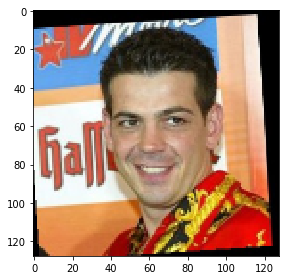

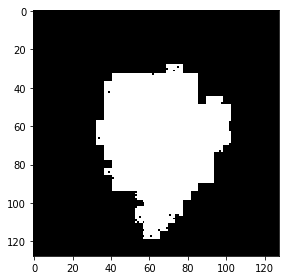

C:\Users\Ashish\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


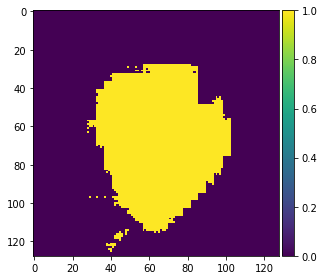

In [36]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from scipy.misc import imread, imresize, imsave
%matplotlib inline  


# Save masks to output folder
test_ids_ = list(map(lambda x:x.replace('img','mask'),test_ids)) # Convenience, rename the file name list

# Properly shape all test-prediction masks and save them
for i in np.arange(len(preds_test_t)):
    mask_ = np.squeeze(preds_test_t[i])
    mask_ = np.array(mask_*255, dtype='uint8')
    mask_ = imresize(mask_, size=sizes_test[i]) # upsampled masks
    path = os.path.join('Testing_results\Testing mask(Main-code-copy-2)', test_ids_[i])
    imsave(path, mask_)

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
    
    
# (* update) the input_path using your folder path
input_path = "Testing_results\Testing mask(Main-code-copy-2)"

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('Testing_results', 'Main-code-copy-2.csv'), index=False)

print("Completed succesfully....!!! ")

C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\Ashish\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Completed succesfully....!!! 
